#**1.Read and load image dataset**

In [0]:
from PIL import Image
import re
from os import listdir
from os.path import isfile, join
import numpy as np
import random
import shutil

In [0]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

In [0]:
import os
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.stats import pearsonr
from keras import backend as K


#Read images from folder path specified in 'folder'
def read_dataset(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        
        if img is not None:
            img = cv2.resize(img,(64,64))
            images.append(img)
    return images

Using TensorFlow backend.


In [0]:
MIAS_PATH = "./all-mias/"
X_RAY_PATH1 = "./3471833/RawImage/Test1Data/"
X_RAY_PATH2 = "./3471833/RawImage/Test2Data/"
X_RAY_PATH3 = "./3471833/RawImage/TrainingData/"
DENTAL_PATH = "./Dataset/"

In [0]:
mias_set = read_dataset(MIAS_PATH)
Xray_set1 = read_dataset(X_RAY_PATH1)
Xray_set2 = read_dataset(X_RAY_PATH2)
Xray_set3 = read_dataset(X_RAY_PATH3)
dental_set = read_dataset(DENTAL_PATH)

In [0]:
mias_set.extend(Xray_set1)
mias_set.extend(Xray_set2)
mias_set.extend(Xray_set3)
mias_set.extend(dental_set)
dataset = np.array(mias_set)

### Show some images in dataset

In [0]:
dataset.shape

(842, 64, 64)

In [0]:
idx = [841,200,420]

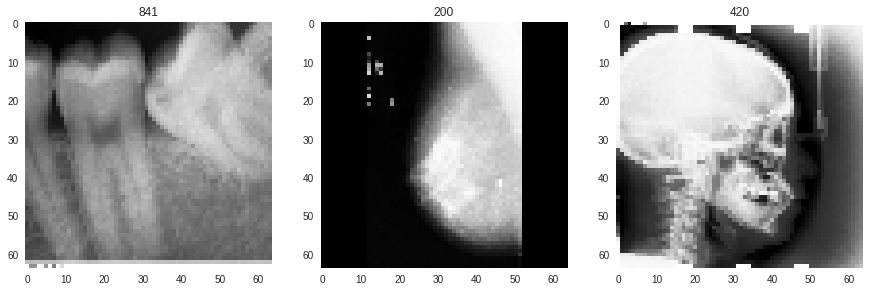

In [0]:
#for i in idx:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx):
    axes[i].imshow(dataset[idx], cmap="Greys_r")
    axes[i].set_title('%d' % idx)

#**2.Preprocessing by adding noise to image**

In [0]:
#Function to add gaussian noise
def gaussian_noise(images,mean,sigma,prop):
    
    noisy_images = []
    for img in images:
        noisy_img = img + prop*np.random.normal(mean, sigma, img.shape)
        noisy_images.append(noisy_img)
   
    return noisy_images

#Function to add poisson noise
def poisson_noise(images,mean,prop):
    noisy_images = []
    for img in images:
        noisy_img = img + prop*np.random.poisson(mean, img.shape)
        noisy_images.append(noisy_img)
   
    return noisy_images

In [0]:
def add_noise_gauss(images):
    batch = images.shape[0]//4;
    noise1 = gaussian_noise(images[0:batch],0,50,0.5)
    noise2 = gaussian_noise(images[batch:2*batch],0,50,0.5)
    noise3 = gaussian_noise(images[2*batch:3*batch],0,50,0.5)
    noise4 = gaussian_noise(images[3*batch:],0,50,0.5)
    
    noisy_set = []
    for data in [noise1,noise2,noise3,noise4]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)

def add_noise_poisson(images):
    noise = poisson_noise(images,0.5,20)
    
    noisy_set = []
    for data in [noise]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)

In [0]:
def pair_shuffle(images,noisy_set):
    # - from 2 initial sets, take each of them and put in the pair
    # - shufle the list of pairs
    # - from shuffled list of pairs, split into 2 numpy ground truth and noisy images
    
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)

In [0]:
images = np.reshape(dataset, (dataset.shape[0],64,64,1))

### **Add gaussain noise**

In [0]:
from random import shuffle
import math
import skimage
from sklearn.metrics import mean_squared_error
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means
from skimage.measure import compare_ssim as ssim

#Shuffling and adding noise to the dataset
shuffle(images)
#Getting the noisy image set
noisy_set = add_noise_gauss(images)
ground_truth,noisy_images = pair_shuffle(images,noisy_set)

In [0]:
ground_truth = ground_truth.astype('float32')
noisy_images = noisy_images.astype('float32')

In [0]:
#Split into training and cross validation
nb_train = 722
train_size = int(nb_train*0.8)
x_train_gt = ground_truth[0:train_size]/255.
x_train_noisy = noisy_images[0:train_size]/255.
x_valid_gt = ground_truth[train_size:nb_train]/255.
x_valid_noisy = noisy_images[train_size:nb_train]/255.
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(577, 64, 64, 1)
(145, 64, 64, 1)


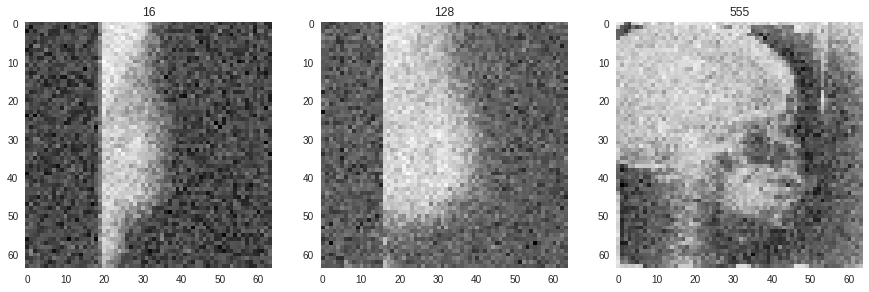

In [0]:
idx_noisy = [16,128,555]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_noisy):
    axes[i].imshow(np.squeeze(x_train_noisy[idx], axis=2), cmap="Greys_r")
    axes[i].set_title('%d' % idx)

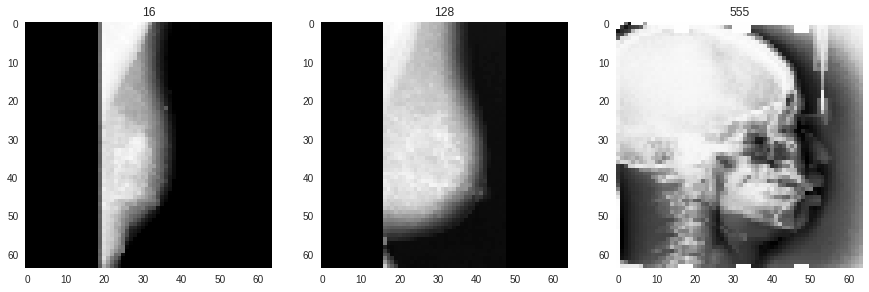

In [0]:
#idx_noisy = [16,128,229]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_noisy):
    axes[i].imshow(np.squeeze(x_train_gt[idx], axis=2), cmap="Greys_r")
    axes[i].set_title('%d' % idx)

# 3.Build Autoencoder model

In [0]:
from keras.layers import LeakyReLU

def DAE_CNN(features_shape, act='linear'):
 
    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Encoder
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='en_conv1')(o)
    o = LeakyReLU(0.1)(o)
    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='en_pool1')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='en_conv2')(o)
    o = LeakyReLU(0.1)(o)
    enc = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='en_pool2')(o)
    
    # Decoder
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='de_conv1')(enc)
    o = LeakyReLU(0.1)(o)
    o = UpSampling2D((2, 2), name='upsampling1')(o)
    o = Conv2D(64, (3, 3), activation=act, padding='same', strides=1, name='de_conv2')(o)
    o = LeakyReLU(0.1)(o)
    o = UpSampling2D((2, 2), name='upsampling2')(o)
    dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same', strides=1, name='de_conv3')(o)
    
    # Print network summary
    autoencoder = Model(inputs=x, outputs=dec)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['accuracy'])
    
    autoencoder.summary()
    return autoencoder

In [0]:
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU)

input_shape=x_train_noisy[0].shape
autoenc = DAE_CNN(input_shape) #, act=LeakyReLU(alpha=0.1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
en_conv1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
en_pool1 (MaxPooling2D)      (None, 32, 32, 64)        0         
_________________________________________________________________
en_conv2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
en_pool2 (MaxPooling2D)      (None, 16, 16, 64)        0         
__________

In [0]:
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
model_checkpoint = ModelCheckpoint('./first_cnn_autoencoder.hdf5',monitor = 'loss', verbose = 1,save_best_only=True)

In [0]:
import h5py
#Training the model
history = autoenc.fit(x_train_noisy, x_train_gt,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_valid_noisy, x_valid_gt),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True),model_checkpoint])

Train on 577 samples, validate on 145 samples
Epoch 1/100
577/577 [==============================] - 2s 4ms/step - loss: 0.3991 - acc: 0.3617 - val_loss: 0.3407 - val_acc: 0.3770

Epoch 00001: loss improved from inf to 0.39909, saving model to ./first_cnn_autoencoder.hdf5
Epoch 2/100
577/577 [==============================] - 2s 3ms/step - loss: 0.3474 - acc: 0.3668 - val_loss: 0.3332 - val_acc: 0.3771

Epoch 00002: loss improved from 0.39909 to 0.34741, saving model to ./first_cnn_autoencoder.hdf5
Epoch 3/100
577/577 [==============================] - 2s 3ms/step - loss: 0.3378 - acc: 0.3670 - val_loss: 0.3259 - val_acc: 0.3772

Epoch 00003: loss improved from 0.34741 to 0.33781, saving model to ./first_cnn_autoencoder.hdf5
Epoch 4/100
577/577 [==============================] - 2s 3ms/step - loss: 0.3330 - acc: 0.3671 - val_loss: 0.3319 - val_acc: 0.3768

Epoch 00004: loss improved from 0.33781 to 0.33296, saving model to ./first_cnn_autoencoder.hdf5
Epoch 5/100
577/577 [=============

**Test for gaussian noise**

In [0]:
#Getting images to test
def get_testing_images(ground_truth, noisy_images):
    test_images_gt = ground_truth[722:]/255.
    test_images_noisy = noisy_images[722:]/255.
    print (test_images_noisy.shape)
    print (test_images_gt.shape)
    return (test_images_gt,test_images_noisy)

In [0]:
test_images_gt, test_images_noisy = get_testing_images(ground_truth, noisy_images)

(120, 64, 64, 1)
(120, 64, 64, 1)


In [0]:
out_autoencoder = autoenc.predict(test_images_noisy, verbose=1)
out_autoencoder.shape

120/120 [==============================] - 0s 2ms/step


(120, 64, 64, 1)

*PSNR and SSIM function*

In [0]:
from sklearn.metrics import mean_squared_error

def get_psnr(imageA,imageB):
    maxI = 1.0
    try:
        return 20*math.log10(maxI) - 10*math.log10(mean_squared_error(imageA.flatten(),imageB.flatten()))
    except:
        return 20*math.log10(maxI)

def get_psnr_result(x_test, out):
    psnr_sum = 0
    for i in range(out.shape[0]):
        psnr_sum += get_psnr(x_test[i].reshape(64,64),out[i].reshape(64,64))
        
    return 1.0*psnr_sum/out.shape[0];

def get_ssim_result(originalSet,noisySet):
    ssim_sum = 0
    originalSet = originalSet.reshape(originalSet.shape[0],64, 64, 1)
    noisySet = noisySet.reshape(noisySet.shape[0],64, 64, 1)
    for i in range(originalSet.shape[0]):
        ssim_sum += ssim(originalSet[i], noisySet[i],data_range=originalSet[i].max() - noisySet[i].min(), multichannel=True)
    return 1.0*ssim_sum/originalSet.shape[0]

*Non-local mean filter*

In [0]:
def nlm_denoise(noisy_image):
    noisy_image = noisy_image.reshape(noisy_image.shape[0],64,64)
    noisy_image = noisy_image*255.0
    denoised = []
    
    for image in noisy_image:
        denoised_image = denoise_nl_means(image, 7, 11, 0.5)
        denoised.append(denoised_image)
        
    return np.array(denoised)

In [0]:
nlm_out = nlm_denoise(test_images_noisy)
nlm_out = nlm_out.astype('float32')/255.0

/usr/local/lib/python3.6/dist-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


In [0]:
def median_filter(noisy_set, kernel=3):
    med_set = np.zeros(noisy_set.shape, dtype=float)
    for i in range(noisy_set.shape[0]):
        im_med = cv2.medianBlur(noisy_set[i].astype('float32'), kernel)
        med_set[i] = np.expand_dims(im_med, axis=2)
        
    return med_set

In [0]:
median_out = median_filter(test_images_noisy).astype('float32')

In [0]:
print("psnr of noisy set:", get_psnr_result(test_images_noisy, test_images_gt))
print("psnr of median filter:", get_psnr_result(median_out, test_images_gt))
print("psnr of non-local mean filter:", get_psnr_result(nlm_out, test_images_gt))
print("psnr of CNN_DAE:", get_psnr_result(out_autoencoder, test_images_gt))

psnr of noisy set: 20.17624388036769
psnr of median filter: 25.488806784050624
psnr of non-local mean filter: 20.17624388036769
psnr of CNN_DAE: 29.4176428156238


In [0]:
print("ssim of noisy set:", get_ssim_result(test_images_gt, test_images_noisy))
print("ssim of median filter:", get_ssim_result(test_images_gt, median_out))
print("ssim of non-local mean filter:", get_ssim_result(test_images_gt, nlm_out))
print("ssim of CNN_DAE:", get_ssim_result(test_images_gt, out_autoencoder))

ssim of noisy set: 0.42119919754169605
ssim of median filter: 0.5898980133417541
ssim of non-local mean filter: 0.42119919754169605
ssim of CNN_DAE: 0.8715594162950887


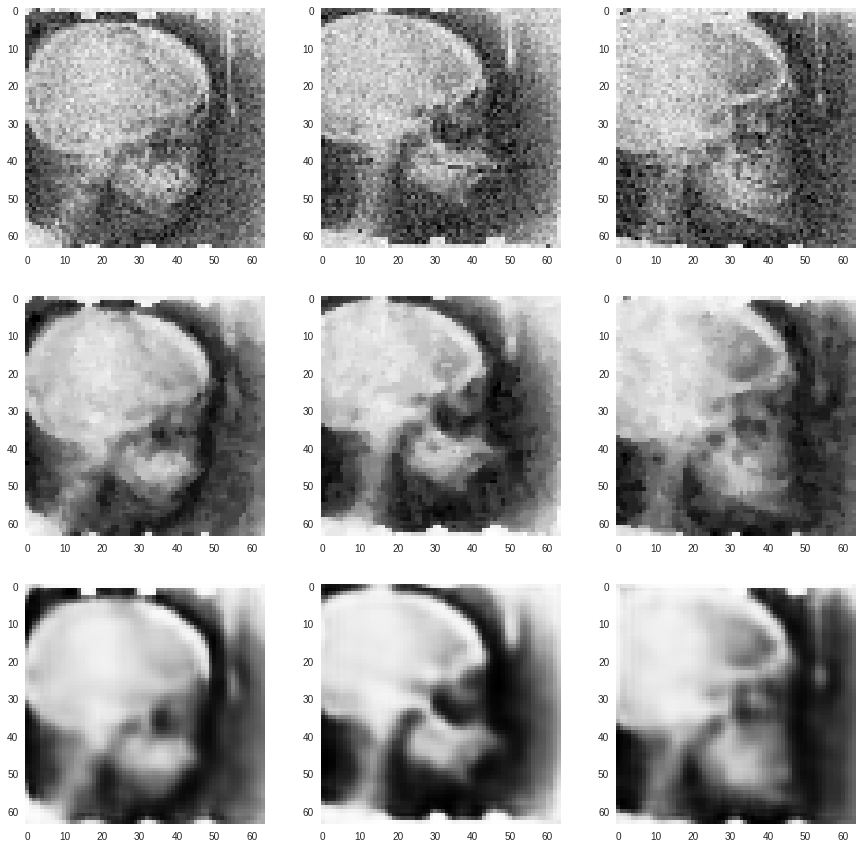

In [0]:
id_gausse = [95, 10, 110]
rows = 3
columns = 3
fig = plt.figure(figsize=(15, 15))
for i in range( columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax = fig.add_subplot(rows, columns, i+1)
    #ax[-1].set_title("ax:"+str(i))  # set title
    if i<3:
        ax.imshow(np.squeeze(test_images_noisy[id_gausse[i%3]], axis=2), cmap='Greys_r')
    elif 3<=i<6:
        ax.imshow(np.squeeze(median_out[id_gausse[i%3]], axis=2), cmap='Greys_r')
    else:
        ax.imshow(np.squeeze(out_autoencoder[id_gausse[i%3]], axis=2), cmap='Greys_r')
plt.show()
fig.savefig('gausse_denoise_model')

###**Combine median filter with CNN_DEA for gaussian noise**

In [0]:
x_train_noisy_med = median_filter(x_train_noisy, kernel=3).astype('float32')
x_valid_noisy_med = median_filter(x_valid_noisy, kernel=3).astype('float32')
print(x_train_noisy_med.shape)
print(x_valid_noisy_med.shape)

(577, 64, 64, 1)
(145, 64, 64, 1)


In [0]:
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU)
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint

input_shape=x_train_noisy_med[0].shape
autoencoder_gauss_median = DAE_CNN(input_shape)
model_checkpoint = ModelCheckpoint('./first_cnn_autoencoder.hdf5',monitor = 'loss', verbose = 1,save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
en_conv1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
en_pool1 (MaxPooling2D)      (None, 32, 32, 64)        0         
_________________________________________________________________
en_conv2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
en_pool2 (MaxPooling2D)      (None, 16, 16, 64)        0         
__________

In [0]:
autoencoder_gauss_median.fit(x_train_noisy_med, x_train_gt,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_valid_noisy_med, x_valid_gt),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True),model_checkpoint])

Train on 577 samples, validate on 145 samples
Epoch 1/100
577/577 [==============================] - 2s 4ms/step - loss: 0.4097 - acc: 0.3589 - val_loss: 0.3470 - val_acc: 0.3771

Epoch 00001: loss improved from inf to 0.40967, saving model to ./first_cnn_autoencoder.hdf5
Epoch 2/100
577/577 [==============================] - 2s 3ms/step - loss: 0.3474 - acc: 0.3669 - val_loss: 0.3358 - val_acc: 0.3769

Epoch 00002: loss improved from 0.40967 to 0.34743, saving model to ./first_cnn_autoencoder.hdf5
Epoch 3/100
577/577 [==============================] - 2s 3ms/step - loss: 0.3383 - acc: 0.3669 - val_loss: 0.3276 - val_acc: 0.3770

Epoch 00003: loss improved from 0.34743 to 0.33835, saving model to ./first_cnn_autoencoder.hdf5
Epoch 4/100
577/577 [==============================] - 2s 3ms/step - loss: 0.3340 - acc: 0.3669 - val_loss: 0.3338 - val_acc: 0.3774

Epoch 00004: loss improved from 0.33835 to 0.33398, saving model to ./first_cnn_autoencoder.hdf5
Epoch 5/100
577/577 [=============

In [0]:
out_autoenc_gauss_median = autoencoder_gauss_median.predict(test_images_noisy, verbose=1)
out_autoenc_gauss_median.shape

120/120 [==============================] - 0s 3ms/step


(120, 64, 64, 1)

In [0]:
print("psnr of CNN_DAE:", get_psnr_result(out_autoenc_gauss_median, test_images_gt))

psnr of CNN_DAE: 26.052786282829878


In [0]:
print("ssim of CNN_DAE:", get_ssim_result(test_images_gt, out_autoenc_gauss_median))

ssim of CNN_DAE: 0.8423698837308919


# **4.Build model for Poisson noise**

In [0]:
images = np.reshape(dataset, (dataset.shape[0],64,64,1))

In [0]:
from random import shuffle
import math
import skimage
from sklearn.metrics import mean_squared_error
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means
from skimage.measure import compare_ssim as ssim

#Shuffling and adding noise to the dataset
shuffle(images)
#Getting the noisy image set
noisy_set = add_noise_poisson(images)
ground_truth,noisy_images = pair_shuffle(images,noisy_set)

In [0]:
ground_truth = ground_truth.astype('float32')
noisy_images = noisy_images.astype('float32')

In [0]:
#Split into training and cross validation
nb_train = 722
train_size = int(nb_train*0.8)
x_train_gt = ground_truth[0:train_size]/255.
x_train_noisy = noisy_images[0:train_size]/255.
x_valid_gt = ground_truth[train_size:nb_train]/255.
x_valid_noisy = noisy_images[train_size:nb_train]/255.
print(x_train_noisy.shape)
print(x_valid_noisy.shape)

(577, 64, 64, 1)
(145, 64, 64, 1)


In [0]:
input_shape=x_train_noisy[0].shape
autoenc_poisson = DAE_CNN(input_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
en_conv1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
en_pool1 (MaxPooling2D)      (None, 32, 32, 64)        0         
_________________________________________________________________
en_conv2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
en_pool2 (MaxPooling2D)      (None, 16, 16, 64)        0         
__________

In [0]:
#Training the model
history_poisson = autoenc_poisson.fit(x_train_noisy, x_train_gt,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_valid_noisy, x_valid_gt),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True),model_checkpoint])

Train on 577 samples, validate on 145 samples
Epoch 1/100
577/577 [==============================] - 2s 4ms/step - loss: 0.3593 - acc: 0.4665 - val_loss: 0.2909 - val_acc: 0.4742

Epoch 00001: loss did not improve from 0.31132
Epoch 2/100
577/577 [==============================] - 2s 3ms/step - loss: 0.2838 - acc: 0.4757 - val_loss: 0.2836 - val_acc: 0.4740

Epoch 00002: loss improved from 0.31132 to 0.28384, saving model to ./first_cnn_autoencoder.hdf5
Epoch 3/100
577/577 [==============================] - 2s 3ms/step - loss: 0.2778 - acc: 0.4767 - val_loss: 0.2760 - val_acc: 0.4758

Epoch 00003: loss improved from 0.28384 to 0.27782, saving model to ./first_cnn_autoencoder.hdf5
Epoch 4/100
577/577 [==============================] - 2s 3ms/step - loss: 0.2738 - acc: 0.4768 - val_loss: 0.2732 - val_acc: 0.4758

Epoch 00004: loss improved from 0.27782 to 0.27375, saving model to ./first_cnn_autoencoder.hdf5
Epoch 5/100
577/577 [==============================] - 2s 3ms/step - loss: 0.270

**Test poisson model**

In [0]:
test_images_poisson_gt, test_images_poisson_noisy = get_testing_images(ground_truth, noisy_images)

(120, 64, 64, 1)
(120, 64, 64, 1)


In [0]:
out_autoenc_poisson = autoenc_poisson.predict(test_images_poisson_noisy, verbose=1)
out_autoenc_poisson.shape

120/120 [==============================] - 0s 2ms/step


(120, 64, 64, 1)

In [0]:
nlm_out_poisson = nlm_denoise(test_images_poisson_noisy)
nlm_out_poisson = nlm_out.astype('float32')/255.0

/usr/local/lib/python3.6/dist-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


In [0]:
out_median_poisson = median_filter(test_images_poisson_noisy).astype('float32')

In [0]:
print("psnr of noisy set:", get_psnr_result(test_images_poisson_noisy, test_images_poisson_gt))
print("psnr of median filter:", get_psnr_result(out_median_poisson, test_images_poisson_gt))
print("psnr of non-local mean filter:", get_psnr_result(nlm_out_poisson, test_images_poisson_gt))
print("psnr of CNN_DAE:", get_psnr_result(out_autoenc_poisson, test_images_poisson_gt))

psnr of noisy set: 23.360491694944244
psnr of median filter: 26.465805304707153
psnr of non-local mean filter: 8.806100815329964
psnr of CNN_DAE: 31.748813373244737


In [0]:
print("ssim of noisy set:", get_ssim_result(test_images_poisson_gt, test_images_poisson_noisy))
print("ssim of median filter:", get_ssim_result(test_images_poisson_gt, out_median_poisson))
print("ssim of non-local mean filter:", get_ssim_result(test_images_poisson_gt, nlm_out_poisson))
print("ssim of CNN_DAE:", get_ssim_result(test_images_poisson_gt, out_autoenc_poisson))

ssim of noisy set: 0.4581063977966674
ssim of median filter: 0.5757942861021627
ssim of non-local mean filter: 0.3491158405269698
ssim of CNN_DAE: 0.9131138084930425


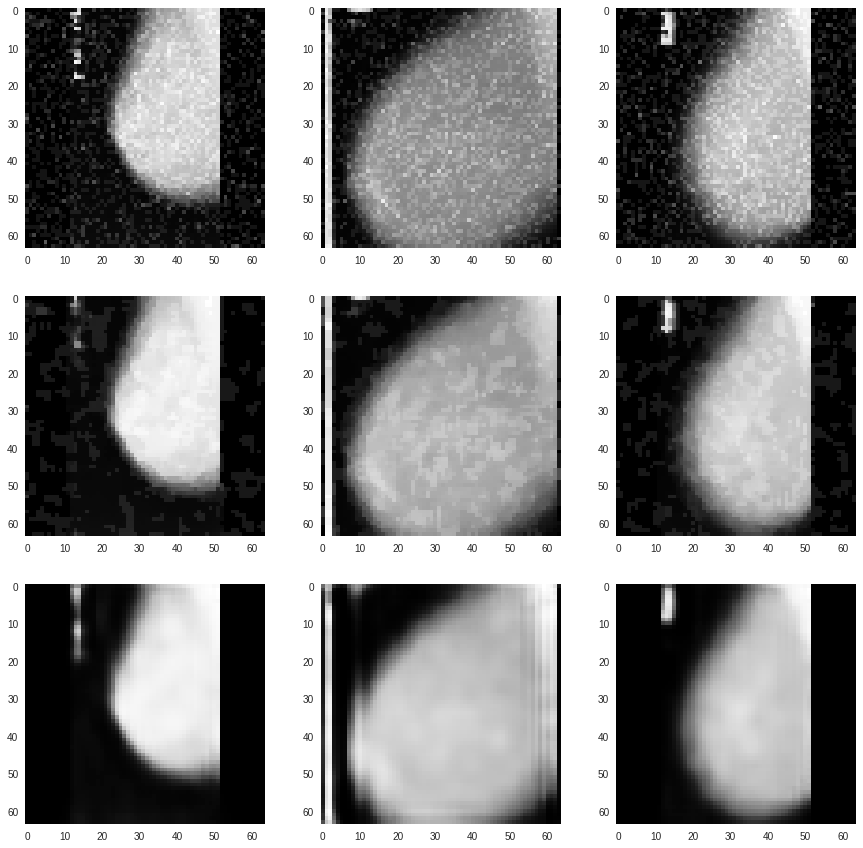

In [0]:
id_poisson = [40, 43, 48]
rows = 3
columns = 3
fig = plt.figure(figsize=(15, 15))
for i in range( columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax = fig.add_subplot(rows, columns, i+1)
    #ax[-1].set_title("ax:"+str(i))  # set title
    if i<3:
        ax.imshow(np.squeeze(test_images_poisson_noisy[id_poisson[i%3]], axis=2), cmap='Greys_r')
    elif 3<=i<6:
        ax.imshow(np.squeeze(out_median_poisson[id_poisson[i%3]], axis=2), cmap='Greys_r')
    else:
        ax.imshow(np.squeeze(out_autoenc_poisson[id_poisson[i%3]], axis=2), cmap='Greys_r')
plt.show()
fig.savefig('poisson_denoise_model')

### **Combine with median filter for poisson denoising **

In [0]:
poisson_train_noisy_med = median_filter(x_train_noisy, kernel=3).astype('float32')
poisson_valid_noisy_med = median_filter(x_valid_noisy, kernel=3).astype('float32')
print(poisson_train_noisy_med.shape)
print(poisson_valid_noisy_med.shape)

(577, 64, 64, 1)
(145, 64, 64, 1)


In [0]:
poisson_train_med_gt = x_train_gt.astype('float32')
poisson_valid_med_gt = x_test_gt.astype('float32')

In [0]:
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU)
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint

input_shape=poisson_train_noisy_med[0].shape
autoencoder_median_poisson = DAE_CNN(input_shape)
model_checkpoint = ModelCheckpoint('./first_cnn_autoencoder.hdf5',monitor = 'loss', verbose = 1,save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
en_conv1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
en_pool1 (MaxPooling2D)      (None, 32, 32, 64)        0         
_________________________________________________________________
en_conv2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
en_pool2 (MaxPooling2D)      (None, 16, 16, 64)        0         
__________

In [0]:
#Training the model
autoencoder_median_poisson.fit(poisson_train_noisy_med, poisson_train_med_gt,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(poisson_valid_noisy_med, poisson_valid_med_gt),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True),model_checkpoint])

Train on 577 samples, validate on 145 samples
Epoch 1/100
577/577 [==============================] - 2s 4ms/step - loss: 0.3482 - acc: 0.4696 - val_loss: 1.0753 - val_acc: 0.3320

Epoch 00001: loss improved from inf to 0.34824, saving model to ./first_cnn_autoencoder.hdf5
Epoch 2/100
577/577 [==============================] - 2s 3ms/step - loss: 0.2844 - acc: 0.4756 - val_loss: 0.9539 - val_acc: 0.3081

Epoch 00002: loss improved from 0.34824 to 0.28443, saving model to ./first_cnn_autoencoder.hdf5
Epoch 3/100
577/577 [==============================] - 2s 3ms/step - loss: 0.2773 - acc: 0.4766 - val_loss: 0.9659 - val_acc: 0.3169

Epoch 00003: loss improved from 0.28443 to 0.27727, saving model to ./first_cnn_autoencoder.hdf5
Epoch 4/100
577/577 [==============================] - 2s 3ms/step - loss: 0.2729 - acc: 0.4768 - val_loss: 0.9513 - val_acc: 0.3061

Epoch 00004: loss improved from 0.27727 to 0.27287, saving model to ./first_cnn_autoencoder.hdf5
Epoch 5/100
577/577 [=============

In [0]:
poisson_autoenc_median_out = autoencoder_median_poisson.predict(test_images_poisson_noisy, verbose=1)
poisson_autoenc_median_out.shape

120/120 [==============================] - 0s 484us/step


(120, 64, 64, 1)

In [0]:
print("psnr of CNN_DAE:", get_psnr_result(poisson_autoenc_median_out, test_images_poisson_gt))

psnr of CNN_DAE: 31.188367538416323


In [0]:
print("ssim of CNN_DAE:", get_ssim_result(test_images_poisson_gt, poisson_autoenc_median_out))

ssim of CNN_DAE: 0.890084463047026


### **Loss of 2 models**

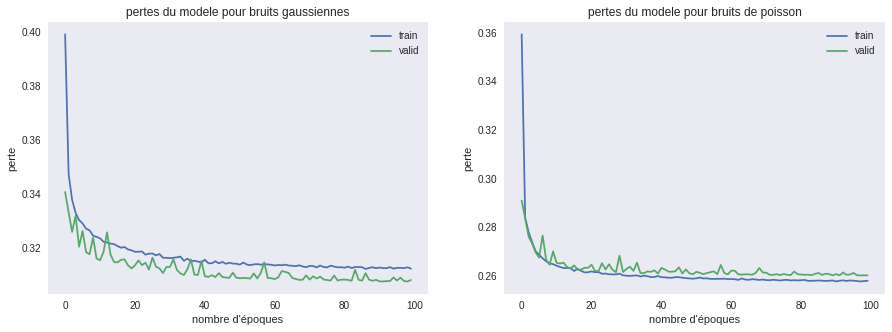

In [0]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
plt.title("pertes du modele pour bruits gaussiennes")
plt.ylabel("perte")
plt.xlabel("nombre d'époques")
ax1.legend(['train', 'valid'], loc='upper right')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(history_poisson.history['loss'])
ax2.plot(history_poisson.history['val_loss'])
plt.title("pertes du modele pour bruits de poisson")
plt.ylabel("perte")
plt.xlabel("nombre d'époques")
ax2.legend(['train', 'valid'], loc='upper right')
plt.show()

fig.savefig('loss')